### required packages

In [9]:
import pickle as pk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cmasher as cmr
from glob import iglob
from ast import literal_eval
from tqdm.auto import tqdm
from copy import deepcopy
from matplotlib import cm 
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Normalizer
%matplotlib inline

### set colormap

In [8]:
mycmap = cm.get_cmap('cmr.amethyst_r', 7)

### code - physics calculations

In [5]:
def get_dcdf(mat):
    dcdf_mat = {}
    for i in range(1,len(mat.columns)):
        dc = mat.iloc[:,i] - mat.iloc[:,i-1]
        df = mat.columns[i] - mat.columns[i-1]
        dcdf = dc / df
        dcdf_mat[mat.columns[i]] = dcdf
    return pd.DataFrame(dcdf_mat)

def get_fdcdf(mat):
    fdcdf_mat = {}
    for i in range(1,len(mat.columns)):
        dc = mat.iloc[:,i] - mat.iloc[:,i-1]
        df = mat.columns[i] - mat.columns[i-1]
        fdcdf = dc / df
        fdcdf_mat[mat.columns[i]] = fdcdf*mat.columns[i]
    return pd.DataFrame(fdcdf_mat)

# Data

### simulations

In [2]:
def clean_data(df):
    return df.fillna(0.0)

Data = pd.read_pickle('checkpoints/all_cvf_data.pickle')
Data = deepcopy(Data[Data.mat.apply(lambda x: x.shape == (100,100))])
Data['mat'] = Data['mat'].apply(clean_data)

### experimental data

In [6]:
Raw_CVF = pd.read_pickle('checkpoints/CS613A2_CVf_matrix_DataFrame.pickle')

# Compute f dC/df from C-V-f profiles

In [4]:
Data['dcdf'] = Data.mat.apply(get_dcdf)
Data['fdcdf'] = Data.mat.apply(get_fdcdf)

Raw = get_fdcdf(Raw_CVF*(1e9)/0.17) # convert from F to nF, and divide by 0.17cm2

# Principal Component Regression

### fit principal components to simulation data - unlabeled & unsupervised

Format data: logged and l2 normalized

In [10]:
X = np.array(list(-Data.fdcdf))
X[X<=0] = 10**-6.5
X = np.log10(X)
n,nv,nf = X.shape
X = X.reshape(n,nv*nf)

mynorm = Normalizer(norm='l2').fit(X)
Xnorm = mynorm.transform(X)

In [11]:
pca = PCA(n_components=200)
pca.fit(Xnorm)

# transform the 2-D matrix [100x100] plots into 2 variable PCA encoding
Z = pca.transform(Xnorm)

for i in range(50):
    Data.loc[:,f'pca{i}'] = Z[:,i]

### on the low-dimensional latent space, fit linear regression to labels - supervised

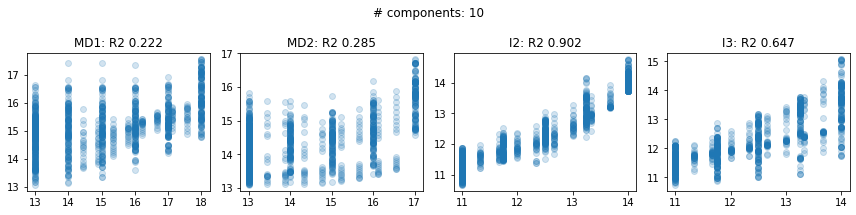

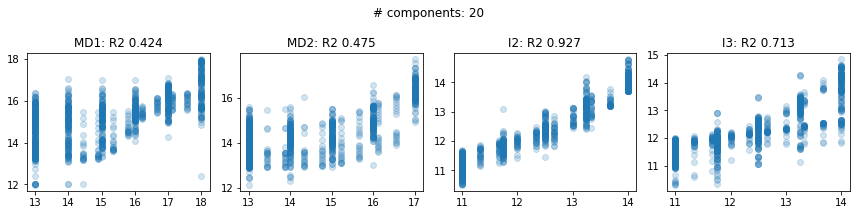

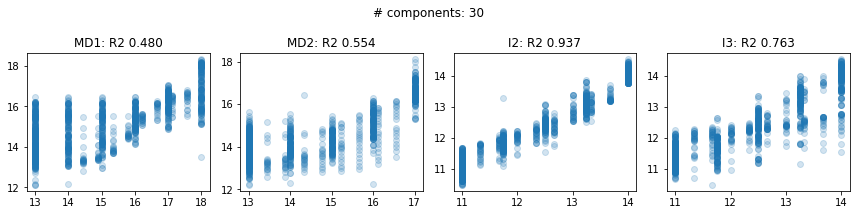

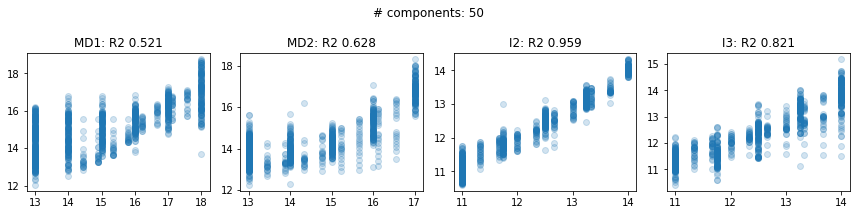

In [23]:
from sklearn.linear_model import LinearRegression
n_comp=50
features=['MD1','MD2','I2','I3']

for n_comp in [10,20,30,50]: #,200,300,500]:
    

    
    f,ax = plt.subplots(1,4, figsize=(16,4))#(4*3,3))
    
    f.suptitle(f'# components: {n_comp}')
    for i in range(4):
        y=np.log10(np.array(Data.loc[:,features[i]]))
        reg = LinearRegression().fit(Z[:,:n_comp], y)
        score = reg.score(Z[:,:n_comp], y)
        
        ax[i].scatter(y, reg.predict(Z[:,:n_comp]), alpha=0.2)
        ax[i].set_title(f'{features[i]} (R2={score:.3f})')
    f.tight_layout()

### prediction for experimental data

In [26]:
# format experimental data as logged and equivalently l2-normalized
n,nvnf = X.shape
RawX = -np.array(Raw).reshape(1,nvnf)
RawX[RawX<=0] = 10**-6.5
RawX = np.log10(RawX)
RawNorm = mynorm.transform(RawX)
# where's it place our experimental data?
RawZ = pca.transform(RawNorm)

for n_comp in [10,20,30,50]: #,200,300,500]:
    print('# components', n_comp)
    score = []
    y=np.log10(np.array(Data.loc[:,features]))
    reg = LinearRegression().fit(Z[:,:n_comp], y)
    # how's it classify the defects in our experimental data?
    print(reg.predict(RawZ[:,:n_comp]))

# components 10
[[11.43994491 17.58723543 13.62523588 11.20212755]]
# components 20
[[12.66274252 16.0254821  14.08575793 12.20847736]]
# components 30
[[12.09248135 17.24331211 13.93879708 14.05965719]]
# components 50
[[13.23744764 14.46222357 15.67554358 11.86171701]]


### look at PC embedding

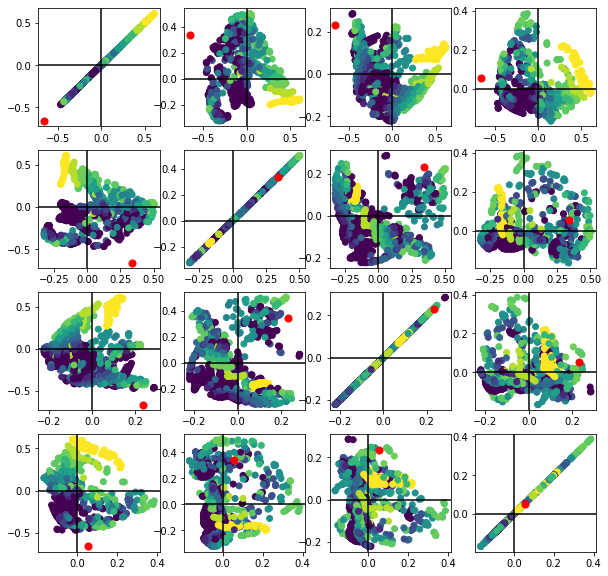

In [27]:
f,ax=plt.subplots(4,4, figsize=(10,10))
#i1,i2=0,1
for i1 in range(4):
    for i2 in range(4):
        ax[i1][i2].scatter(Data[f'pca{i1}'], Data[f'pca{i2}'], c=np.log10(Data['I2'])) #, alpha=0.15)
        ax[i1][i2].scatter([RawZ[0,i1]], [RawZ[0,i2]], c='red', s=50)
        ax[i1][i2].axhline(0,c='k')
        ax[i1][i2].axvline(0,c='k')

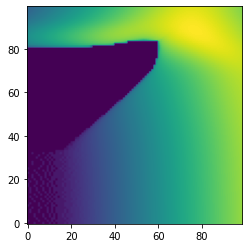

In [42]:
plt.imshow(X[0].reshape(100,99))
plt.gca().invert_yaxis()

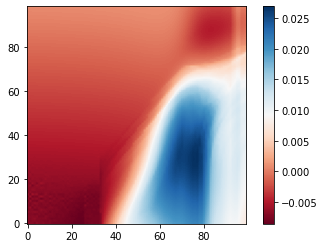

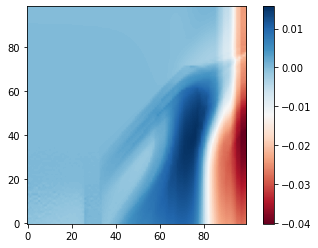

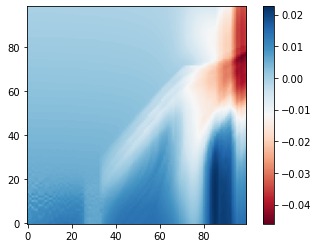

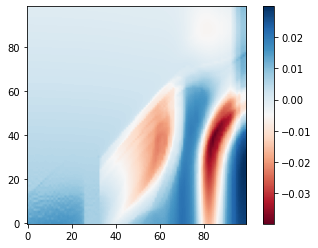

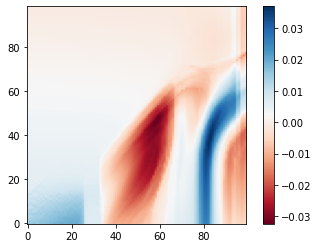

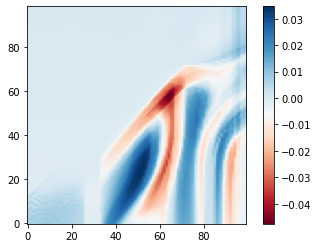

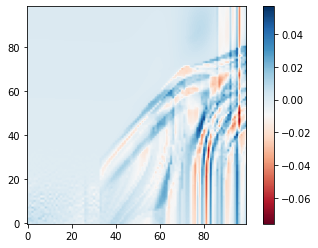

In [32]:
for i in [0,1,2,3,4,9,49]:
    f,ax=plt.subplots()
    cm = plt.imshow(pca.components_[i,:].reshape(100,99).T,
                   cmap='RdBu')
    plt.colorbar(cm)
    ax.invert_yaxis()

# VAE

In [75]:
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm.auto import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from copy import deepcopy
import pandas as pd
import numpy as np
matplotlib.style.use('default')

### VAE code

In [58]:
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=100*99, out_features=512)  #*2)
        #self.enc2 = nn.Linear(in_features=512*2, out_features=512)
        self.enc3 = nn.Linear(in_features=512, out_features=features*2) # N features * 2 (means, and the variation)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=features, out_features=512)
        self.dec2 = nn.Linear(in_features=512, out_features=100*99)
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        #x = F.relu(self.enc2(x))
        x = self.enc3(x).view(-1, 2, features)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
 
        # decoding
        x = F.relu(self.dec1(z))
        reconstruction = torch.sigmoid(self.dec2(x))
        return reconstruction, mu, log_var
    
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD



def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(dataloader): #, total=int(len(train_data)/dataloader.batch_size):
        data, _ = data
        data = data.float().to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad() # purge the gradient from previous data batch
        # Get decoded, and encoded values for the data batch
        reconstruction, mu, logvar = model(data)
        # Get Loss
        bce_loss = criterion(reconstruction, data) # Binary Cross-Entropy
        loss = final_loss(bce_loss, mu, logvar) # Variational Lower Bound
        running_loss += loss.item()
        loss.backward() # compute the gradient at each model parameter necessary to compute "loss"
        optimizer.step() # update the model parameters
    train_loss = running_loss/len(dataloader.dataset)
    # the reported loss is the average loss across all batches in the dataset
    return train_loss


def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(dataloader): #, total=int(len(val_data)/dataloader.batch_size):
            data, _ = data
            data = data.float().to(device)
            data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(val_data)/dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data.view(batch_size, 1, 100, 99)[:8], 
                                  reconstruction.view(batch_size, 1, 100, 99)[:8]))
                save_image(both.cpu(), f"./ml_tests/output/output{epoch}.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    # the reported loss is the average loss across all batches in the dataset
    return val_loss

### Data loading code

In [47]:
import pandas as pd
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self,
                 data_file,
                 transform=None,
                 target_transform=None):
        self.data_file = data_file
        self.labels = np.array(list(pd.read_pickle(data_file).apply(
            lambda x: [x.MD1, x.MD2, x.I2, x.I3], axis=1)))
        self.data = np.array(list(pd.read_pickle(data_file).fdcdf), dtype=float)
        
        # flip sign on fdcdf
        self.data = -self.data
        
        # scale to between 0 and 1
        self.data[self.data <= 0] = 10**-6.5
        self.data = np.log10(self.data)
        self.data = self.data - np.min(self.data)
        self.data = self.data / np.max(self.data)
        
        self.data_len = self.data.shape[0]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [48]:
# transforms (turns data array into pytorch Tensor)
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_data = CustomImageDataset('checkpoints/all_cvf_data_DataFrame_fdcdf.pickle',
                               transform=transform)

In [55]:
val_data = deepcopy(train_data)

### learning parameters

In [45]:
# learning parameters
epochs = 1  #args['epochs'] # number of times model is trained against the full training dataset
batch_size = 64
lr = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### VAE visualization

In [53]:
features = 2
epochs = 50
batch_size = 64
lr = 0.0001

In [63]:
# learning parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# training and validation data loaders
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False
)

model = LinearVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

train_loss = []
val_loss = []
for epoch in tqdm(np.arange(epochs)):
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    if epoch % 5 == 0:
        print(f"Epoch {epoch+1} of {epochs}")
        print(f"Train Loss: {train_epoch_loss:.4f}")
        print(f"Val Loss: {val_epoch_loss:.4f}")
model_viz = deepcopy(model)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 of 50
Train Loss: 6785.8128
Val Loss: 6605.3063
Epoch 6 of 50
Train Loss: 5763.4393
Val Loss: 5741.4804
Epoch 11 of 50
Train Loss: 5681.5893
Val Loss: 5678.1972
Epoch 16 of 50
Train Loss: 5663.1454
Val Loss: 5660.1247
Epoch 21 of 50
Train Loss: 5648.5585
Val Loss: 5648.1720
Epoch 26 of 50
Train Loss: 5637.7978
Val Loss: 5636.9347
Epoch 31 of 50
Train Loss: 5629.3090
Val Loss: 5627.1522
Epoch 36 of 50
Train Loss: 5623.1343
Val Loss: 5621.2509
Epoch 41 of 50
Train Loss: 5618.2971
Val Loss: 5615.7560
Epoch 46 of 50
Train Loss: 5611.6567
Val Loss: 5613.0456


Embed simulation data to visualize

In [104]:
ToEncode = torch.tensor(
    [train_data[i][0].numpy() for i in range(1000)]
).reshape((1000,100*99)).float()

x_viz = F.relu(model_viz.enc1(ToEncode))
#x = F.relu(model.enc2(x))
x_viz = model_viz.enc3(x_viz).view(-1, 2, features)

# get `mu` and `log_var`
mu_viz = x_viz[:, 0, :] # the first feature values as mean
log_var_viz = x_viz[:, 1, :] # the other feature values as variance

Visualize

In [65]:
Y_ToEncode = np.array(
    [train_data[i][1] for i in range(1000)]
).reshape((1000,4))

mkdir: figtests/VAE: File exists


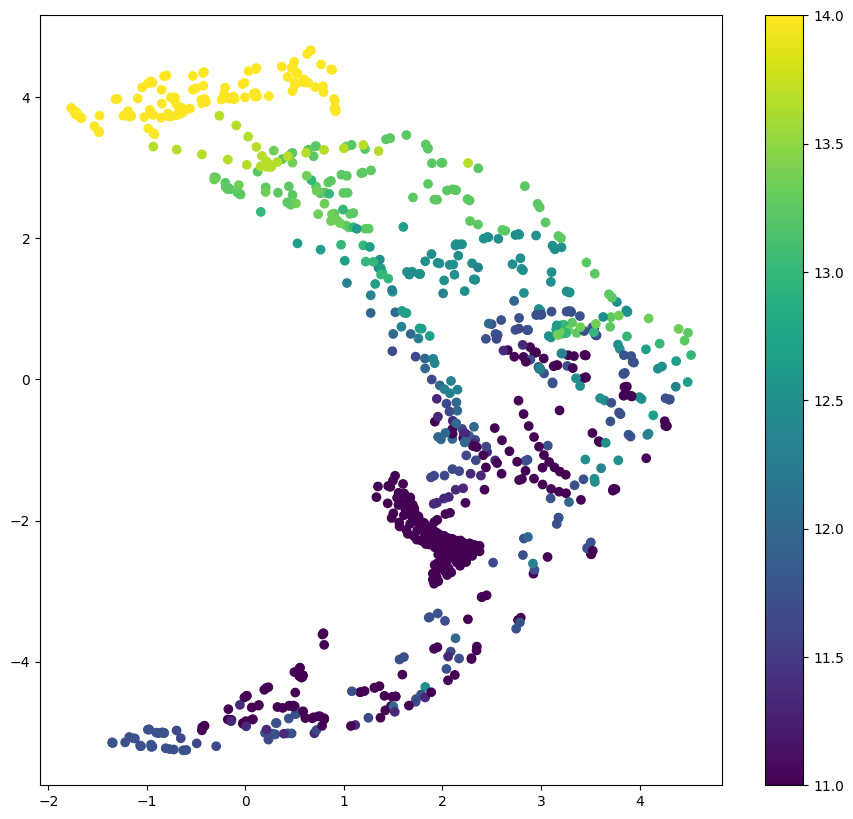

In [108]:
# plot if vae latent space dimensions = 2
cm = plt.scatter(mu_viz[:,0].detach().numpy(), mu_viz[:,1].detach().numpy(), c=np.log10(Y_ToEncode[:,2]))
plt.colorbar(cm)
plt.gcf().set_size_inches(11,10)

### VAE training

In [110]:
features = 30

In [112]:
# learning parameters
epochs = 50  #args['epochs'] # number of times model is trained against the full training dataset
batch_size = 64
lr = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# training and validation data loaders
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False
)

model = LinearVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

train_loss = []
val_loss = []
for epoch in tqdm(np.arange(epochs)):
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    if epoch % 5 == 0:
        print(f"Epoch {epoch+1} of {epochs}")
        print(f"Train Loss: {train_epoch_loss:.4f}")
        print(f"Val Loss: {val_epoch_loss:.4f}")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 of 50
Train Loss: 6781.2631
Val Loss: 6589.5519
Epoch 2 of 50
Train Loss: 6404.4413
Val Loss: 6223.9055
Epoch 3 of 50
Train Loss: 6141.2234
Val Loss: 6069.6414
Epoch 4 of 50
Train Loss: 6026.4482
Val Loss: 5972.4567
Epoch 5 of 50
Train Loss: 5924.3648
Val Loss: 5871.5664
Epoch 6 of 50
Train Loss: 5838.2922
Val Loss: 5806.5356
Epoch 7 of 50
Train Loss: 5786.2354
Val Loss: 5763.0286
Epoch 8 of 50
Train Loss: 5742.9895
Val Loss: 5718.6924
Epoch 9 of 50
Train Loss: 5701.4187
Val Loss: 5683.6874
Epoch 10 of 50
Train Loss: 5673.5482
Val Loss: 5664.6440
Epoch 11 of 50
Train Loss: 5659.3089
Val Loss: 5653.7377
Epoch 12 of 50
Train Loss: 5649.6818
Val Loss: 5644.6769
Epoch 13 of 50
Train Loss: 5641.9821
Val Loss: 5638.0743
Epoch 14 of 50
Train Loss: 5636.5349
Val Loss: 5634.1324
Epoch 15 of 50
Train Loss: 5631.6002
Val Loss: 5628.3781
Epoch 16 of 50
Train Loss: 5626.3712
Val Loss: 5624.4676
Epoch 17 of 50
Train Loss: 5622.3095
Val Loss: 5620.6856
Epoch 18 of 50
Train Loss: 5617.9572
Val

## predicting defects from simulated C-V-f maps from VAE latent space

In [222]:
from sklearn.linear_model import LinearRegression
x = torch.Tensor([train_data[i][0].flatten().numpy() for i in range(1000)])
x = F.relu(model.enc1(x))
#x = F.relu(model.enc2(x))
x = model.enc3(x).view(-1, 2, features)
# get `mu` and `log_var`
mu = x[:, 0, :] # the first feature values as mean
log_var = x[:, 1, :] # the other feature values as variance

y=np.log10(Y_ToEncode)
xs=mu.detach().numpy()
reg = LinearRegression().fit(xs, y)

In [229]:
y = np.array([np.log10(train_data[i][1]) for i in range(1000)])

In [238]:
xR = F.relu(model.enc1(torch.Tensor(RawData).reshape(1,9900)))
zR = model.enc3(xR).view(-1, 2, features)
#oR = F.relu(model.dec1(zR))
#reconstruction = torch.sigmoid(model.dec2(oR))

[16.755089]
[7.6724663]
[14.715925]
[17.16241]


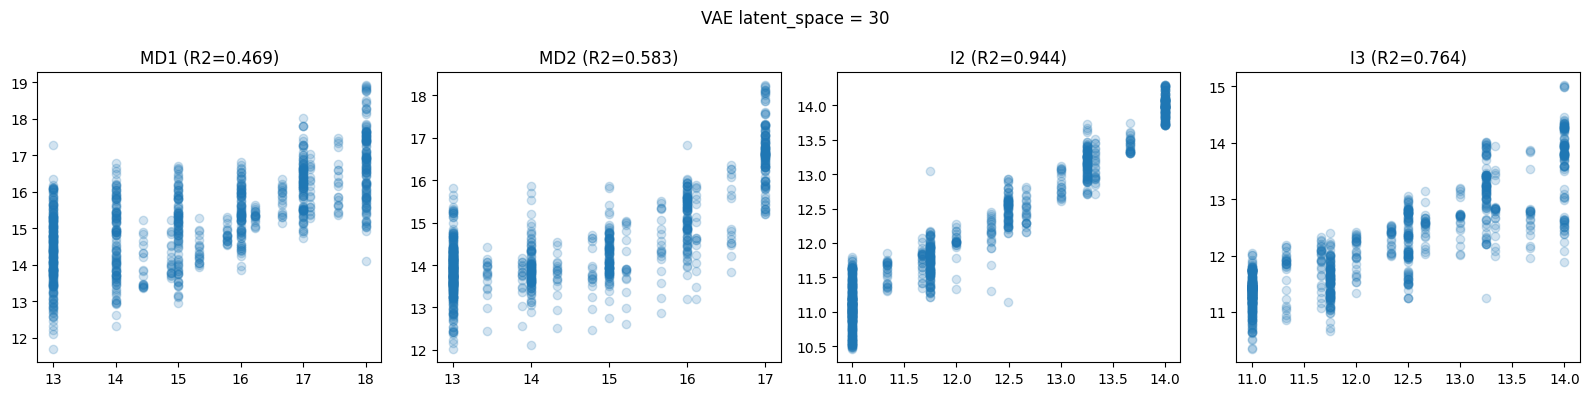

In [246]:
from sklearn.linear_model import LinearRegression
defect_features=['MD1','MD2','I2','I3']

f,ax = plt.subplots(1,4, figsize=(16,4))#(4*3,3))

f.suptitle(f'VAE latent_space = {features}')

for i in range(4):
    y = np.log10(np.array([train_data[j][1][i] for j in range(1000)]))
    reg = LinearRegression().fit(xs, y)
    score = reg.score(xs, y)
    
    ax[i].scatter(y, reg.predict(xs), alpha=0.2)
    ax[i].set_title(f'{defect_features[i]} (R2={score:.3f})')
    
    print(reg.predict(zR[0,0,:].detach().numpy().reshape(1,30)))
f.tight_layout()

### predicting the defects of experimental C-V-f map

In [167]:
RawData = -np.array(Raw).flatten()
RawData[RawData<= 0] = 10**-3.5
RawData = np.log10(RawData)
RawData = RawData - np.min(RawData)
RawData = RawData / np.max(RawData)

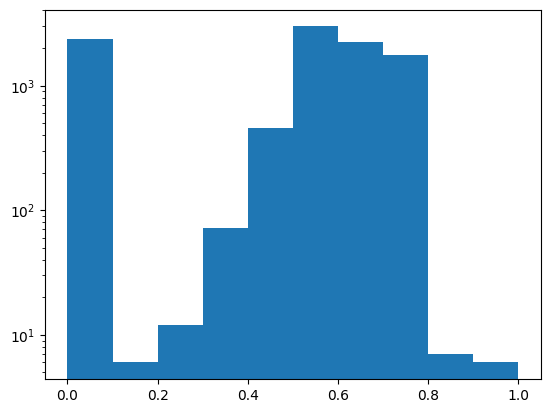

In [166]:
plt.hist(RawData.flatten())
plt.gca().set_yscale('log')

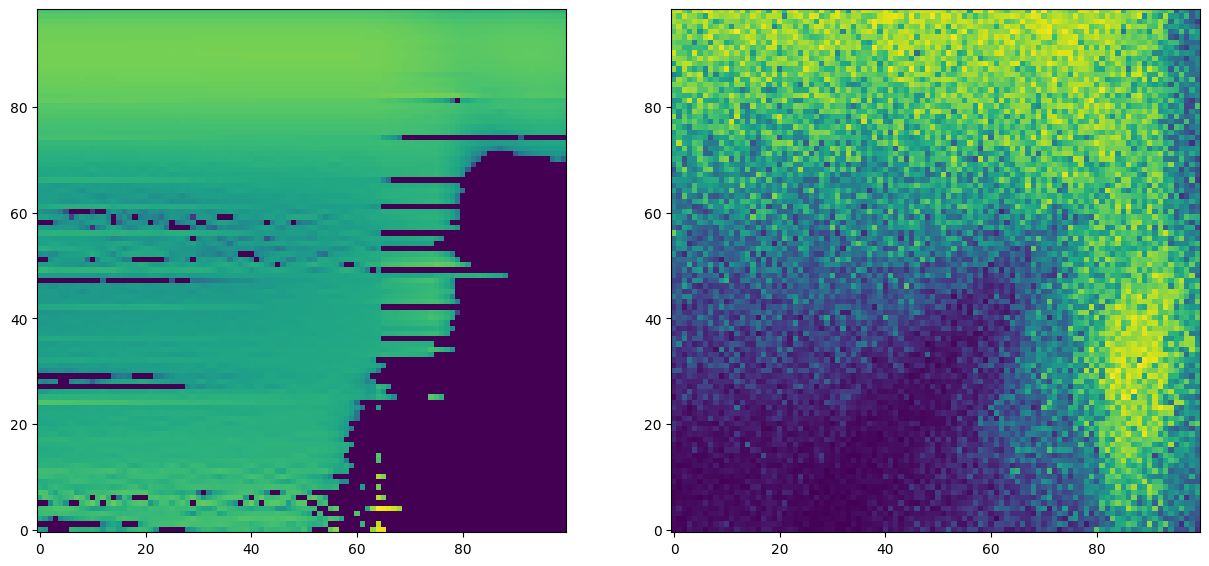

In [180]:
xR = F.relu(model_viz.enc1(torch.Tensor(RawData)))
#x = F.relu(model.enc2(x))
zR = model_viz.enc3(xR).view(-1, 2, 2)
oR = F.relu(model_viz.dec1(zR))
reconstruction = torch.sigmoid(model.dec2(oR))

f,ax=plt.subplots(1,2,figsize=(15,7.5))
ax[0].imshow(RawData.reshape(100,99).T)
ax[0].invert_yaxis()
                  
ax[1].imshow(reconstruction[0,0,:].detach().numpy().reshape(100,99).T)
ax[1].invert_yaxis()

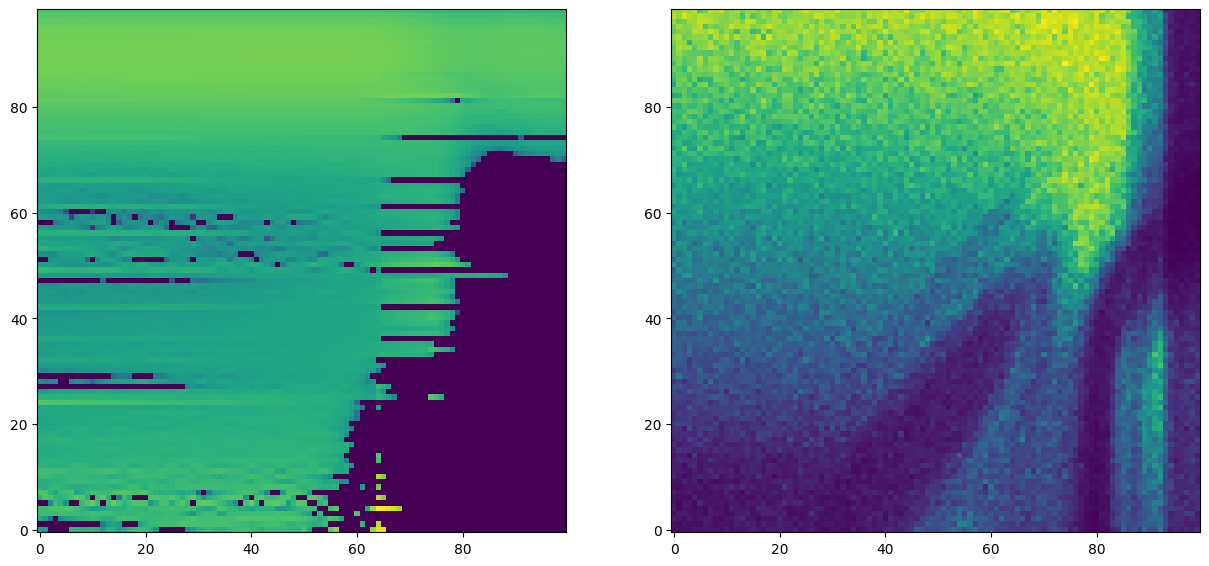

In [168]:
xR = F.relu(model.enc1(torch.Tensor(RawData)))
#x = F.relu(model.enc2(x))
zR = model.enc3(xR).view(-1, 2, features)
oR = F.relu(model.dec1(zR))
reconstruction = torch.sigmoid(model.dec2(oR))

f,ax=plt.subplots(1,2,figsize=(15,7.5))
ax[0].imshow(RawData.reshape(100,99).T)
ax[0].invert_yaxis()
                  
ax[1].imshow(reconstruction[0,0,:].detach().numpy().reshape(100,99).T)
ax[1].invert_yaxis()

In [176]:
xR = F.relu(model_viz.enc1(torch.Tensor(RawData)))
#x = F.relu(model.enc2(x))
zR = model_viz.enc3(xR).view(-1, 2, 2)
muR = zR[0][0]

mkdir: figtests/VAE: File exists


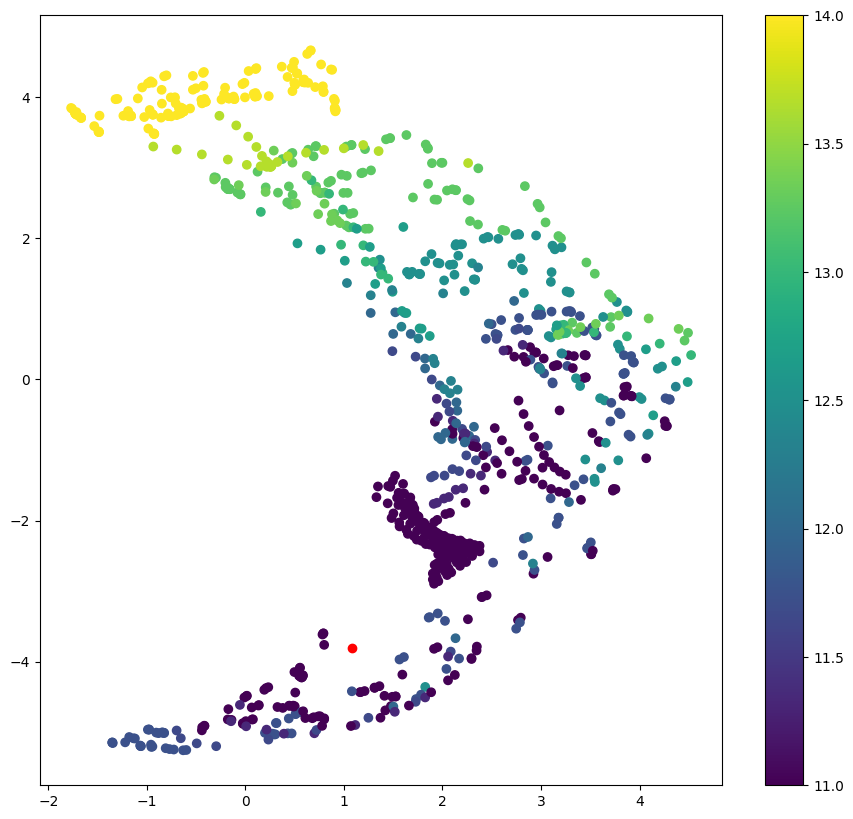

In [181]:
# plot if vae latent space dimensions = 2
cm = plt.scatter(mu_viz[:,0].detach().numpy(), mu_viz[:,1].detach().numpy(), c=np.log10(Y_ToEncode[:,2]))
plt.colorbar(cm)
plt.gcf().set_size_inches(11,10)
plt.scatter([muR[0].detach().numpy()], [muR[1].detach().numpy()], c='r')

In [ ]:
# format experimental data as logged and equivalently l2-normalized

for n_comp in [10,20,30,50]: #,200,300,500]:
    print('# components', n_comp)
    score = []
    y=np.log10(np.array(Data.loc[:,features]))
    reg = LinearRegression().fit(Z[:,:n_comp], y)
    # how's it classify the defects in our experimental data?
    print(reg.predict(RawZ[:,:n_comp]))

In [ ]:
x = F.relu(model.enc1(ToEncode))
#x = F.relu(model.enc2(x))
z = model.enc3(x).view(-1, 2, features)
o = F.relu(model.dec1(z))
reconstruction = torch.sigmoid(model.dec2(o))